In [ ]:
import pandas as pd
import rioxarray
import xarray as xr
from netCDF4 import Dataset
import geopandas
# from utilities.weatherFunctions import *
# from utilities.geographicFunctions import *

In [ ]:
import bokeh
from bokeh.layouts import *
from bokeh.models import *
import matplotlib as mpl

from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models import Span

# Measuring impact of heatwaves in the Philippines

What is heatwave? 


HWDI:
Heat Index: 

How is the Philippines affected by heat? 
Recent months - extreme heat 

In this notebook, we visualize the areas within Filipino cities that are adversely impacted by heat using multiple data sources 

Step 1: Using Population of the Philippines we pick 4 cities 
Step 1.1 Visualize population using ADMIN 1, 2, 3 
Step 1.2 Visualize population HEX Grid 7

Step 2: Historical heatwave analysis 
using GLDAS data to identify heatwaves from a variation of the WMO formula
Step 2.1 Observations from this chart - Ananda

Step 3: Historical heat index analysis 
Heat Index is a better measure to understand the health impact of excess heat 
Step 3.1 Observations from histrocal heat index using GLDAS data 

Step 4: Using Tomorrow.io data to get granular heat index 
Step 4.2 Foursquare grid 

Step 5: using PAGASA heat index data to compare 

Step 6: Greencover and heat index

Step 7: Electricity distribution, green cover and heat index

Heatwaves are generally understood to be the combination of extreme temperatures over multiple days. A more quantitative definition, however, is very contested and there is no definitive answer, with different characterizations being useful at different times or contexts.

They can be dangerous to the human body and very damaging to plants, animals, and structures. With climate change, they will probably become more frequent and longer, putting much of the world at risk. 

The urban regions in the Philippines have a compound vulnerability to heatwaves. Its position as part of Southeast Asia, with high temperatures and humidity already being the norm, and the 7641 islands that make up the country are especially susceptible to climate change. Challenges in exposition, vulnerability, and adaptability to climate made the Philippines become the country with highest extreme weather disaster-related risk in the world according to the 2022 World Risk Report. Additionally, about 40% of the Philippine’s population lives in cities, and rapid urbanization is expected to continue as “drought and low farm productivity” drive migrants into cities. The consequences of heatwaves to these residents will be profound, and call for new methods to better understand their behaviors and propose better mitigation strategies. This intersects with the high inequality found in Filipino cities: in the first semester of 2021, driven by the Covid-19 pandemic, 23.7% of the country’s overall population was considered poor. Studies have shown strong correlation between poverty and vulnerability to heatwaves, and low-income housing has poor thermal performance and high thermal discomfort levels across the globe. Even without taking into consideration socioeconomic status, a vast majority of Filipinos experience heat stress severely (as self-reported), and this increases with population density.

The serious consequences are already being felt, with recent months showcasing extreme temperatures. In April 2023, for example, dangerous heat was observed throughout the country.

In this notebook, we visualize the areas within Filipino cities that are adversely impacted by heat using multiple data sources, and try to understand some of the aspects that have led to this upending crisis.

A special thank you to the Philippine Atmospheric, Geophysical and Astronomical Services Administration (PAGASA), which kindly provided us with their data and was very helpful.

## Visualizing Population

Read the shapefiles for Philippines

In [ ]:
PHILIPPINES  = geopandas.read_file('../../data/shapefiles/philippines/phl_adminboundaries_candidate_exclude_adm3/phl_admbnda_adm1_psa_namria_20200529.shp')
MANILA = PHILIPPINES[PHILIPPINES['ADM2_EN'].isin(['National Capital Region'])]
PHILIPPINES_ADM3 = geopandas.read_file('../../data/shapefiles/philippines/phl_adminboundaries_candidate_adm3/phl_admbnda_adm3_psa_namria_20200529.shp')
DAVAO = PHILIPPINES_ADM3[PHILIPPINES_ADM3['ADM3_EN'].isin(['Davao City'])]
ZAMBOANGA = PHILIPPINES_ADM3[PHILIPPINES_ADM3['ADM3_EN'].isin(['Zamboanga City'])]
CEBU = PHILIPPINES_ADM3[PHILIPPINES_ADM3['ADM3_EN'].isin(['Cebu City'])]

Read population data for the Philippines

In [ ]:
import dask.dataframe as dd
import dask_geopandas as dg
population = pd.read_csv('../../data/population/phl_general_2020.csv')
#population_dg = dg.from_dask_dataframe(population)

In [ ]:
import geopandas as gpd
geometry = gpd.points_from_xy(population['longitude'], population['latitude'])
population_gdf = geopandas.GeoDataFrame(population, geometry=geometry)

In [ ]:
population_adm3 = PHILIPPINES_ADM3.sjoin(population_gdf)


In [ ]:
population_adm3 = population_adm3[['ADM3_EN', 'phl_general_2020']].groupby(['ADM3_EN']).sum().reset_index()
population_adm1 = population_adm2[['ADM1_EN', 'phl_general_2020']].groupby(['ADM1_EN']).sum().reset_index()

In [ ]:
PHILIPPINES_ADM3 = PHILIPPINES_ADM3.merge(population_adm3, on = 'ADM3_EN')

In [ ]:
PHILIPPINES_ADM1 = PHILIPPINES.merge(population_adm1, on = 'ADM1_EN')

In [ ]:
#PHILIPPINES_ADM3

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,6))
plt.rcParams["font.family"] = "cursive"

PHILIPPINES_ADM2.plot(column='phl_general_2020', legend = True, ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xticks([])
ax.set_yticks([])

In [ ]:
PHILIPPINES_ADM1.to_file('../../data/population/phl_adm1.geojson')

## Historical Heatwave Analysis

In this notebook, we will explore heatwaves incidence, based on [pre-calculated data](https://worldbankgroup.sharepoint.com.mcas.ms/teams/DevelopmentDataPartnershipCommunity-WBGroup/Shared%20Documents/Forms/AllItems.aspx?csf=1&web=1&e=Yvwh8r&cid=fccdf23e%2D94d5%2D48bf%2Db75d%2D0af291138bde&FolderCTID=0x012000CFAB9FF0F938A64EBB297E7E16BDFCFD&id=%2Fteams%2FDevelopmentDataPartnershipCommunity%2DWBGroup%2FShared%20Documents%2FProjects%2FHeatwaves%20Data%20Collaborative%2FData%2Fremotesensing%2Fhwdi%5F5degC&viewid=80cdadb3%2D8bb3%2D47ae%2D8b18%2Dc1dd89c373c5) obtained from NASA's [GLDAS](https://ldas.gsfc.nasa.gov/gldas). 

First, let's take a look at the "ds_mean2" data, which comes from the Heatwave Duration Index (HWDI). In it, a heatwave is defined as 2 consecutive days where the mean temperature is more than 5 degrees of the mean temperature of the baseline from 1948 to 2014.


In [ ]:
# parallel ensures that it is being parallel processed
ds_mean2_gldas=xr.open_mfdataset("../../data/gldas/ymean2/wld_cli_*.nc4", parallel = True)

Now let's take a look at how the Philippines have fared under recent years

In [ ]:
def clip_area(ds, area):

    ds.rio.write_crs("EPSG:4326", inplace=True)
    clipped_area = ds.rio.clip(area.geometry.values,all_touched=True, drop=True)

    return clipped_area

In [ ]:
clipped_phil=clip_area(ds_mean2_gldas, PHILIPPINES)
clipped_phil

In [ ]:
clipped_phil.to_dataframe().groupby(['time']).mean().reset_index().plot(x='time',y='heat_waves_per_time_period')
#clipped_phil.to_dataframe().groupby(['time']).mean().reset_index().plot(x='time',y='heat_wave_duration_index_wrt_mean_of_reference_period')

### National Capital Region

In [ ]:
clipped_ncr=clip_area(ds_mean2_gldas,MANILA)
ncr_mean2=clipped_ncr.to_dataframe().groupby(['time']).mean().reset_index()
ncr_mean2.plot(x='time',y='heat_waves_per_time_period')

### Cebu City

In [ ]:
clipped_cebu=clip_area(ds_mean2_gldas, CEBU)
clipped_cebu.to_dataframe().groupby(['time']).mean().reset_index().plot(x='time',y='heat_waves_per_time_period')

There is no data recorded for the region, showcasing a probable weakness in the ds_mean2 data

### Zamboanga City

In [ ]:
clipped_zamb=clip_area(ds_mean2_gldas, ZAMBOANGA)
clipped_zamb.to_dataframe().groupby(['time']).mean().reset_index().plot(x='time',y='heat_waves_per_time_period')

### Davao City

In [ ]:
clipped_davao=clip_area(ds_mean2_gldas, DAVAO)
clipped_davao.to_dataframe().groupby(['time']).mean().reset_index().plot(x='time',y='heat_waves_per_time_period')

It appears the "ds_mean2" definition is not particularly relevant and does not include complete data, since most of the provinces observed do not have heatwaves before 2010 in this dataset, which seems incredibly unlikely.

## Historical Heat Index Analysis

In [ ]:
def add_city_name(df, city_name):
    df['city'] = city_name

    return df

In [ ]:
manila_heatindex = add_city_name(pd.read_csv('../../data/gldas/heatindex/manila_heat_index_daily.csv'), 'Manila')
davao_heatindex = add_city_name(pd.read_csv('../../data/gldas/heatindex/davao_heat_index_daily.csv'), 'Davao')
zamboanga_heatindex = add_city_name(pd.read_csv('../../data/gldas/heatindex/zamboanga_heat_index_daily.csv'), 'Zamboanga')
cebu_heatindex = add_city_name(pd.read_csv('../../data/gldas/heatindex/cebu_heat_index_daily.csv'), 'Cebu')

In [ ]:
# phl_cities_hwdi_mean2 = pd.concat([manila_hwdi_mean2, zamboanga_hwdi_mean2, davao_hwdi_mean2, cebu_hwdi_mean2])
phl_cities_heatindex = pd.concat([manila_heatindex, zamboanga_heatindex, davao_heatindex, cebu_heatindex])

In [ ]:
from datetime import datetime
phl_cities_heatindex['time'] = phl_cities_heatindex['time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [ ]:
phl_cities_heatindex_year = phl_cities_heatindex[['city', 'time', 'heat_index']].groupby([pd.Grouper(key='time', freq='Y'), 'city']).agg({'mean', 'max', 'min'}).reset_index()
phl_cities_heatindex_year.set_index(['time', 'city'], inplace=True)
phl_cities_heatindex_year.columns = phl_cities_heatindex_year.columns.droplevel(0)
phl_cities_heatindex_year.reset_index(inplace=True)

In [ ]:
phl_cities_heatindex_month = phl_cities_heatindex[['city', 'time', 'heat_index']].groupby([pd.Grouper(key='time', freq='M'), 'city']).agg({'mean', 'max', 'min'}).reset_index()
phl_cities_heatindex_month.set_index(['time', 'city'], inplace=True)
phl_cities_heatindex_month.columns = phl_cities_heatindex_month.columns.droplevel(0)

In [ ]:
output_notebook()
phl_cities_heatindex_month.reset_index(inplace=True)
show(get_line_plot(phl_cities_heatindex_month, measure = 'max', title = 'Max Heat Index Per Month', subtitle = 'Heat index is calculated using both temperature and relative humidity', source= 'GLDAS data with analysis from the Data Lab, World Bank'))

## tomorrow.io Granular Heat Index Analysis

is there a way to embed the foursquare into here?
https://studio.foursquare.com/map/0b43c93d-427b-4534-8d47-8dcf0676b0f2

## Data from PAGASA Comparison

In order to get more comparison points, we reached out to the Philippine Atmospheric, Geophysical and Astronomical Services Administration (PAGASA).

In [5]:
pag_dav = pd.read_csv("/Users/anandafigueiredo/GitHub/Not Pushed Yet/HeatIndex_March-June2023/HI_dailyaverage-March-June 2023/heat index_daily_mean_Davao City, Davao Del Sur_dailyaverage.csv")
pag_cebu = pd.read_csv("/Users/anandafigueiredo/GitHub/Not Pushed Yet/HeatIndex_March-June2023/HI_dailyaverage-March-June 2023/heat index_daily_mean_Mactan International Airport, Cebu_dailyaverage.csv")
pag_pasay = pd.read_csv("/Users/anandafigueiredo/GitHub/Not Pushed Yet/HeatIndex_March-June2023/HI_dailyaverage-March-June 2023/heat index_daily_mean_NAIA Pasay City, M.Manila_dailyaverage.csv")
pag_port = pd.read_csv('/Users/anandafigueiredo/GitHub/Not Pushed Yet/HeatIndex_March-June2023/HI_dailyaverage-March-June 2023/heat index_daily_mean_Port Area, Manila_dailyaverage.csv')
pag_quezon = pd.read_csv('/Users/anandafigueiredo/GitHub/Not Pushed Yet/HeatIndex_March-June2023/HI_dailyaverage-March-June 2023/heat index_daily_mean_Science Garden Quezon City, Metro Manila_dailyaverage.csv')
pag_zamb = pd.read_csv('/Users/anandafigueiredo/GitHub/Not Pushed Yet/HeatIndex_March-June2023/HI_dailyaverage-March-June 2023/heat index_daily_mean_Zamboanga City, Zamboanga Del Sur_dailyaverage.csv')

In [56]:
pag_dav = pd.read_csv("/Users/anandafigueiredo/GitHub/Not Pushed Yet/HeatIndex_March-June2023/HI_dailymaximum-March-June 2023/heat index_daily_max_Davao City, Davao Del Sur_dailymax.csv")
pag_cebu = pd.read_csv("/Users/anandafigueiredo/GitHub/Not Pushed Yet/HeatIndex_March-June2023/HI_dailymaximum-March-June 2023/heat index_daily_max_Mactan International Airport, Cebu_dailymax.csv")
pag_pasay = pd.read_csv("/Users/anandafigueiredo/GitHub/Not Pushed Yet/HeatIndex_March-June2023/HI_dailymaximum-March-June 2023/heat index_daily_max_NAIA Pasay City, M.Manila_dailymax.csv")
pag_port = pd.read_csv('/Users/anandafigueiredo/GitHub/Not Pushed Yet/HeatIndex_March-June2023/HI_dailymaximum-March-June 2023/heat index_daily_max_Port Area, Manila_dailymax.csv')
pag_quezon = pd.read_csv('/Users/anandafigueiredo/GitHub/Not Pushed Yet/HeatIndex_March-June2023/HI_dailymaximum-March-June 2023/heat index_daily_max_Science Garden Quezon City, Metro Manila_dailymax.csv')
pag_zamb = pd.read_csv('/Users/anandafigueiredo/GitHub/Not Pushed Yet/HeatIndex_March-June2023/HI_dailymaximum-March-June 2023/heat index_daily_max_Zamboanga City, Zamboanga Del Sur_dailymax.csv')

Text(0.5, 1.0, 'Heat Index in Deg Celsius for five different points of PHL')

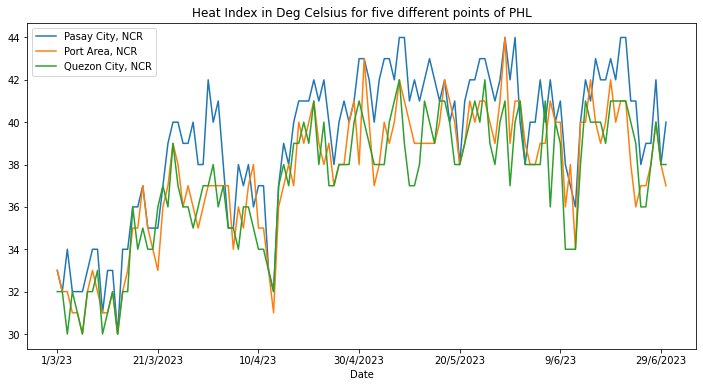

In [57]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(12, 6))

# pag_dav.plot(ax=ax, x='Date', y='Average Heat Index', label='Davao del Sur')
# pag_cebu.plot(ax=ax, x='Date', y='Average Heat Index', label='Cebu')
pag_pasay.plot(ax=ax, x='Date', y='Maximum Heat Index', label='Pasay City, NCR')
pag_port.plot(ax=ax, x='Date', y='Maximum Heat Index', label='Port Area, NCR')
pag_quezon.plot(ax=ax, x='Date', y='Maximum Heat Index', label='Quezon City, NCR')
# pag_zamb.plot(ax=ax, x='Date', y='Average Heat Index', label='Zamboanga City')

plt.title("Heat Index in Deg Celsius for five different points of PHL")

Most "famous" HW was in late April, but the one in late May/early June seems to have been even more impactful for NCR

Appending the coordinates of weather stations to the data that PAGASA also kindly provided

In [58]:
#Pasay
pag_pasay['lat'] = 14.5047
pag_pasay['lon'] = 121.0167

#Quezon
pag_quezon['lat'] = 14.6451
pag_quezon['lon'] = 121.0419

#Port Area, Manila
pag_port['lat'] = 14.5884
pag_port['lon'] = 120.9679

#Cebu
pag_cebu['lat'] = 10.3223
pag_cebu['lon'] = 123.963

#Davao 
pag_dav['lat'] = 7.1277
pag_dav['lon'] = 125.655

#Zamboanga City
pag_zamb['lat'] = 6.9171
pag_zamb['lon'] = 122.0663

In [60]:
# Converting time to DateTime
from datetime import datetime

#pag_pasay['Date'] = pag_pasay['Date'].apply(lambda x: datetime.strptime(x,'%d/%m/%Y'))
pag_quezon['Date'] = pag_quezon['Date'].apply(lambda x: datetime.strptime(x,'%d/%m/%Y'))
# pag_port['Date'] = pag_port['Date'].apply(lambda x: datetime.strptime(x,'%d/%m/%Y'))
# pag_cebu['Date'] = pag_cebu['Date'].apply(lambda x: datetime.strptime(x,'%d/%m/%Y'))
# pag_dav['Date'] = pag_dav['Date'].apply(lambda x: datetime.strptime(x,'%d/%m/%Y'))
# pag_zamb['Date'] = pag_zamb['Date'].apply(lambda x: datetime.strptime(x,'%d/%m/%Y'))

type: time data '1/3/23' does not match format '%d/%m/%Y'

Creating GeoDataFrame objects from the data of different parts of the PHL

In [53]:
geometry = geopandas.points_from_xy(pag_pasay.lon, pag_pasay.lat, crs="EPSG:4326")
gdf_pasay = geopandas.GeoDataFrame(pag_pasay, geometry=geometry)

geometry1 = geopandas.points_from_xy(pag_quezon.lon, pag_quezon.lat, crs="EPSG:4326")
gdf_quezon = geopandas.GeoDataFrame(pag_quezon, geometry=geometry1)

geometry2 = geopandas.points_from_xy(pag_port.lon, pag_port.lat, crs="EPSG:4326")
gdf_port = geopandas.GeoDataFrame(pag_port, geometry=geometry2)

geometry3 = geopandas.points_from_xy(pag_cebu.lon, pag_cebu.lat, crs="EPSG:4326")
gdf_cebu = geopandas.GeoDataFrame(pag_cebu, geometry=geometry3)

geometry4 = geopandas.points_from_xy(pag_dav.lon, pag_dav.lat, crs="EPSG:4326")
gdf_davao = geopandas.GeoDataFrame(pag_dav, geometry=geometry4)

geometry5 = geopandas.points_from_xy(pag_zamb.lon, pag_zamb.lat, crs="EPSG:4326")
gdf_zamb = geopandas.GeoDataFrame(pag_zamb, geometry=geometry5)

In [54]:
# convert to geojson so we can open it on squarespace
gdf_pasay.to_file('pag_pasay_max.geojson', driver="GeoJSON")
gdf_quezon.to_file('pag_quezon_max.geojson', driver="GeoJSON")
gdf_port.to_file('pag_port_max.geojson', driver="GeoJSON")
gdf_cebu.to_file('pag_cebu_max.geojson', driver="GeoJSON")
gdf_davao.to_file('pag_davao_max.geojson', driver="GeoJSON")
gdf_zamb.to_file('pag_zamb_max.geojson', driver="GeoJSON")

In [9]:
import folium
m = gdf_pasay.explore(color ='brown', marker_type=folium.CircleMarker(radius = 5))
m = gdf_quezon.explore(m=m,color = 'purple', marker_type=folium.CircleMarker(radius = 5))
m = gdf_port.explore(m=m,color = 'red', marker_type=folium.CircleMarker(radius = 5))
m = gdf_cebu.explore(m=m,color = 'orange', marker_type=folium.CircleMarker(radius = 5))
m = gdf_davao.explore(m=m, color = 'pink', marker_type=folium.CircleMarker(radius = 5))
gdf_zamb.explore(m=m,color = 'blue', marker_type=folium.CircleMarker(radius = 5))

## Greencover and HI

## Electricity Distribution, Green Cover and Heat Index

# References

-> add citations from Blog Intro
https://benny.istan.to/blog/20220803-heat-wave-duration-index
https://public.wmo.int/en
https://www.ipcc.ch
http://www.cnnphilippines.com/news/2023/4/23/dangerous-temperaturs-heat-index.html

In [ ]:
color_palette = [  '#4E79A7',  # Blue
    '#F28E2B',  # Orange
    '#E15759',  # Red
    '#76B7B2',  # Teal
    '#59A14F',  # Green
    '#EDC948',  # Yellow
    '#B07AA1',  # Purple
    '#FF9DA7',  # Pink
    '#9C755F',  # Brown
    '#BAB0AC',  # Gray
    '#7C7C7C',  # Dark gray
    '#6B4C9A',  # Violet
    '#D55E00',  # Orange-red
    '#CC61B0',  # Magenta
    '#0072B2',  # Bright blue
    '#329262',  # Peacock green
    '#9E5B5A',  # Brick red
    '#636363',  # Medium gray
    '#CD9C00',  # Gold
    '#5D69B1',  # Medium blue
]

In [ ]:
bokeh.core.validation.silence(EMPTY_LAYOUT, True)

def get_line_plot(heatwaves,title, source, markers=False, subtitle=None, measure = 'heat_index', category = 'city'):

    p2 = figure(x_axis_type = 'datetime', width = 1000, height = 400, toolbar_location='above')
    p2.add_layout(Legend(), "right")

    for id, city in enumerate(heatwaves['city'].unique()):
        df = heatwaves[heatwaves[category]==city].groupby('time').mean().reset_index()[['time', measure]]
        p2.line(df['time'], df[measure], line_width=2, line_color = color_palette[id], legend_label=city)

    # p2.legend.click_policy='hide'
    # if subtitle is not None:
    #     p2.title = subtitle

    p2.title = title
    # title_fig = figure(title=title, toolbar_location=None,width=1000, height=40, )
    # title_fig.title.align = "left"
    # title_fig.title.text_font_size = "20pt"
    # title_fig.border_fill_alpha = 0
    # title_fig.outline_line_width=0

    # #with silence(MISSING_RENDERERS):
    sub_title = figure(title=source, toolbar_location=None,width=1000, height=40, )
    sub_title.title.align = "left"
    sub_title.title.text_font_size = "10pt"
    sub_title.title.text_font_style="normal"
    sub_title.border_fill_alpha = 0
    sub_title.outline_line_width=0

    layout = column(p2, sub_title)

#     if markers:
#         p2.renderers.extend([
#         Span(
#             location=datetime(2020, 3, 15),
#             dimension="height",
#             line_color='#7C7C7C',
#             line_width=2,
#             line_dash=(4,4)
#       ),
#         Span(
#             location=datetime(2021, 2, 15),
#             dimension="height",
#             line_color='#7C7C7C',
#             line_width=2,
#             line_dash=(4,4)
#         ),
#     ]
# )

    return layout

In [ ]:
ds_mean2_gldas=xr.open_mfdataset("../../data/gldas/ymean2/wld_cli_*.nc4", parallel = True)

## Comparing HWDI, Heat Index from NASA GLDAS along with PASAY PHL Govt Heat Index Data

In [ ]:
manila_hwdi_mean2 = add_city_name(clip_area(ds_mean2_gldas, MANILA).to_dataframe().reset_index(), 'Manila')
davao_hwdi_mean2 = add_city_name(clip_area(ds_mean2_gldas, DAVAO).to_dataframe().reset_index(), 'Davao')
zamboanga_hwdi_mean2 = add_city_name(clip_area(ds_mean2_gldas, ZAMBOANGA).to_dataframe().reset_index(), 'Zamboanga')
cebu_hwdi_mean2 = add_city_name(clip_area(ds_mean2_gldas, CEBU).to_dataframe().reset_index(), 'Cebu')

In [ ]:
manila_heatindex = add_city_name(pd.read_csv('../../data/gldas/heatindex/manila_heat_index_daily.csv'), 'Manila')
davao_heatindex = add_city_name(pd.read_csv('../../data/gldas/heatindex/davao_heat_index_daily.csv'), 'Davao')
zamboanga_heatindex = add_city_name(pd.read_csv('../../data/gldas/heatindex/zamboanga_heat_index_daily.csv'), 'Zamboanga')
cebu_heatindex = add_city_name(pd.read_csv('../../data/gldas/heatindex/cebu_heat_index_daily.csv'), 'Cebu')

In [ ]:
manilaport_heatindex_pasay = add_city_name(gpd.read_file('../../data/pasay/pag_port.geojson'), 'Manila Port')
manilaquezon_heatindex_pasay = add_city_name(gpd.read_file('../../data/pasay/pag_quezon.geojson'), 'Quezon')
manilapasay_heatindex_pasay = add_city_name(gpd.read_file('../../data/pasay/pag_pasay.geojson'), 'Pasay')

In [ ]:
manilaport_heatindex_max = add_city_name(gpd.read_file('../../data/pasay/pag_port_max.geojson'), 'Manila Port')
manilaquezon_heatindex_max = add_city_name(gpd.read_file('../../data/pasay/pag_quezon_max.geojson'), 'Quezon')
manilapasay_heatindex_max = add_city_name(gpd.read_file('../../data/pasay/pag_pasay_max.geojson'), 'Pasay')

In [ ]:
phl_cities_heatindex_pasay = pd.concat([manilaport_heatindex_pasay, manilaquezon_heatindex_pasay, manilapasay_heatindex_pasay])

In [ ]:
from datetime import datetime
manilaport_heatindex_max['Date'] = manilaport_heatindex_max['Date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))
#manilaquezon_heatindex_max['Date'] = manilaquezon_heatindex_max['Date'].apply(lambda x: datetime.strptime(x, '%d/%m/%y'))

In [ ]:
phl_cities_heatindex_pasay_max = pd.concat([manilaport_heatindex_max, manilaquezon_heatindex_max, manilapasay_heatindex_max])

In [ ]:
manilaquezon_heatindex_max['Date'] = pd.to_datetime(manilaquezon_heatindex_max[['Year', 'Month', 'Day']])

In [ ]:
phl_cities_heatindex_pasay_max.rename(columns = {'Date':'time'}, inplace=True)

In [ ]:
phl_cities_hwdi_mean2 = pd.concat([manila_hwdi_mean2, zamboanga_hwdi_mean2, davao_hwdi_mean2, cebu_hwdi_mean2])
phl_cities_heatindex = pd.concat([manila_heatindex, zamboanga_heatindex, davao_heatindex, cebu_heatindex])

In [ ]:
from datetime import datetime
phl_cities_heatindex['time'] = phl_cities_heatindex['time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [ ]:
phl_cities_heatindex_year = phl_cities_heatindex[['city', 'time', 'heat_index']].groupby([pd.Grouper(key='time', freq='Y'), 'city']).agg({'mean', 'max', 'min'}).reset_index()
phl_cities_heatindex_year.set_index(['time', 'city'], inplace=True)
phl_cities_heatindex_year.columns = phl_cities_heatindex_year.columns.droplevel(0)
phl_cities_heatindex_year.reset_index(inplace=True)

In [ ]:
phl_cities_heatindex_month = phl_cities_heatindex[['city', 'time', 'heat_index']].groupby([pd.Grouper(key='time', freq='M'), 'city']).agg({'mean', 'max', 'min'}).reset_index()
phl_cities_heatindex_month.set_index(['time', 'city'], inplace=True)
phl_cities_heatindex_month.columns = phl_cities_heatindex_month.columns.droplevel(0)

In [ ]:
phl_cities_heatindex_pasay['time'] = phl_cities_heatindex_pasay['Date']

In [ ]:
manila_heatindex_tomorrowio = pd.read_csv('../../data/tomorrow.io/manila1_20230401_20230504_polygon.csv')

In [ ]:
from datetime import datetime
manila_heatindex_tomorrowio['startTime'] = manila_heatindex_tomorrowio['startTime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))

In [ ]:
manila_heatindex_tomorrowio = manila_heatindex_tomorrowio.groupby(['startTime']).mean()[['heat_index_new_C', 'heat_index_new', 'maxTemperature']].reset_index()

In [ ]:
manila_heatindex_tomorrowio['city'] = 'Manila'

In [ ]:
manila_heatindex_tomorrowio.rename(columns = {'startTime':'time', 'heat_index_new_C':'Maximum Heat Index'}, inplace=True)

In [ ]:
manila_heatindex_tomorrowio.boxplot('Maximum Heat Index')


In [ ]:
phl_cities_heatindex_pasay_max

In [ ]:
output_notebook()
show(get_line_plot(pd.concat([manila_heatindex_tomorrowio, phl_cities_heatindex_pasay_max]), measure = 'Maximum Heat Index', title = 'Average Heat Index', subtitle = 'heat index calculated from Tomorrow.io', source= 'Tomorrow.io'))

In [ ]:
output_notebook()
show(get_line_plot(phl_cities_heatindex_pasay, measure = 'Average Heat Index', title = 'Average Heat Index', subtitle = 'heat index calculated from NWS(2011)', source= 'PAGASA, Govt of Philippines'))

In [ ]:
output_notebook()
show(get_line_plot(phl_cities_hwdi_mean2, measure = 'heat_waves_per_time_period', title = 'Heatwaves per time period', subtitle = 'heatwave is defined as 2 consecutive days where the mean temperature is more than 5 degrees of the mean temperature of the baseline from 1948 to 2014', source= 'GLDAS data with analysis from the Data Lab, World Bank'))

In [ ]:
output_notebook()
from bokeh.models import Panel
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []

for value in list(['min', 'max', 'mean']):

    tabs.append(Panel(child=get_line_plot(phl_cities_heatindex_year.reset_index(), f"Heat Index Per Year", "Source: ACLED",measure=value,  subtitle = 'Heat index is calculated using both temperature and relative humidity'), title=value.capitalize()
                ))

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

In [ ]:
output_notebook()
from bokeh.models import Panel
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []

for value in list(['min', 'max', 'mean']):

    tabs.append(Panel(child=get_line_plot(phl_cities_heatindex_month.reset_index(), f"Heat Index Per Year", "Source: ACLED",measure=value,  subtitle = 'Heat index is calculated using both temperature and relative humidity'), title=value.capitalize()
                ))

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

In [ ]:
output_notebook()
phl_cities_heatindex_month.reset_index(inplace=True)
show(get_line_plot(phl_cities_heatindex_month, measure = 'max', title = 'Max Heat Index Per Month', subtitle = 'Heat index is calculated using both temperature and relative humidity', source= 'GLDAS data with analysis from the Data Lab, World Bank'))